# **Aplicaciones Financieras de ML & AI**
## **Examen II:** *Objetos Financieros Parte I*

#### Nombre: Julio César Avila Torreblanca

- **Problema 1:**:
    1. Descargue datos del precio del dólar en pesos mexicanos, use Yahoo Finance.
    2. Proponer una red de arquitectura LSTM que realice una predicción (forecast)
de la serie de tiempo anterior. ¿Es posible mejorar los resultados de un modelo ARIMA?
    3. ¿Es posible utilizar redes neuronales recurrentes en lugar de un modelo
ARCH?, Intente implementarlo y observe los resultados.


- **Contenido del notebook**:
    1. Librerías y parámetros
    2. Lectura de los datos
    3. Forecasting con ARIMA
    4. Forecasting con GARCH
    5. Forecasting con LSTM
    6. Conclusiones



# 1. Librerías y parámetros

In [6]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.5 MB/s eta 0:00:00


In [76]:
# data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import yfinance as yf

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# modeling
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# test
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 2. Lectura de los datos

In [8]:
data = yf.download(
        tickers = "MXN=X", # dollar price
        period = "1y", # one year information
        interval = "1d", # daily information
    ).loc[:, 'Close']

data = data.rename(columns={'MXN=X': 'dollar_price'})
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,dollar_price
Date,
2024-04-04,16.527000
2024-04-05,16.573200
2024-04-08,16.452000
2024-04-09,16.314301
2024-04-10,16.383310
...,...
2025-04-01,20.474030
2025-04-02,20.328341
2025-04-03,20.258301


# 3. Forecasting con ARIMA
Los pasos a seguir son:
- Validar si la serie de tiempo es estacionaria, caso contrario, transformar los datos.
- Obtener los valores de p,q
- Entrenar las combinaciones $ARIMA(p,d,q)$
- Seleccionar el mejor modelo
- Análisis de resultados

## 3.1 *Estacionalidad*

In [9]:
# uso de test Dickey-Fuller para ver si la st es estacionaria
ADF_result = adfuller(data['dollar_price'])

print('ADF test con los datos originales:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los datos originales:
-> ADF Statistic: -1.8149703263850325
-> p-value: 0.3730550781771602


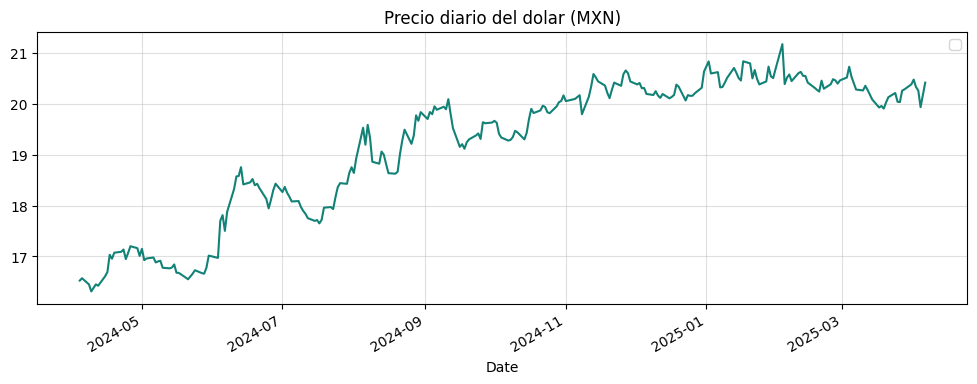

In [10]:
data['dollar_price'].plot(
    figsize = (12,4),
    color='#128277'
)

plt.title("Precio diario del dolar (MXN)")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Dado que p-value > 0.05 no se rechaza la hipótesis nula, por ende la serie de tiempo no es estacionaria.

Probaremos con los retornos logaritmicos.

In [11]:
data['log_returns'] = np.log(data['dollar_price']) - np.log(data['dollar_price'].shift(1))
data = data.dropna()

ADF_result = adfuller(data['log_returns'])

print('ADF test con los retornos logarítmicos:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los retornos logarítmicos:
-> ADF Statistic: -12.668103579937222
-> p-value: 1.261812238413855e-23


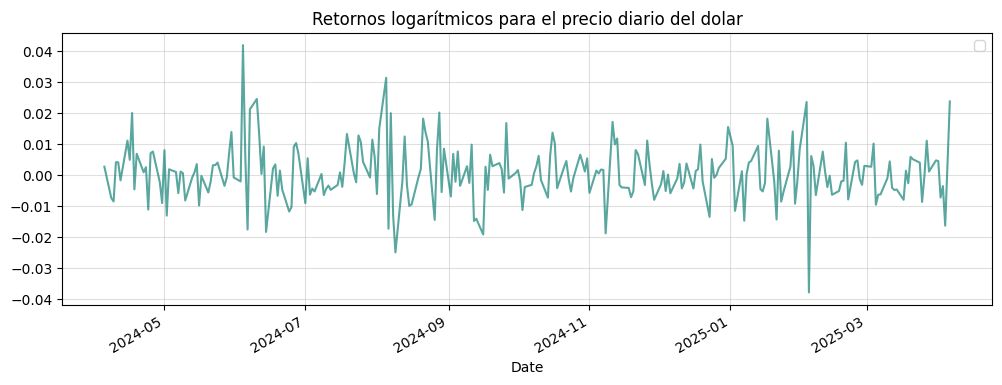

In [12]:
data['log_returns'].plot(
    figsize = (12,4),
    color='#128277',
    alpha=0.7
)

plt.title("Retornos logarítmicos para el precio diario del dolar")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Aquí p-value < 0.05, por lo que tomando los retornos logarítmicos del dolar obtenemos una serie de tiempo estacionaria. Trabajaremos con esta.

## 3.2 Obtener $p$, $q$

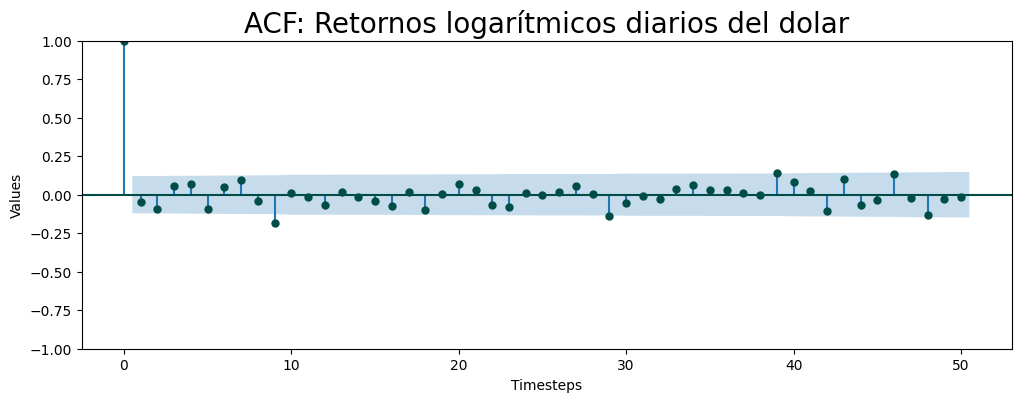

In [13]:
# ACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_acf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'ACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

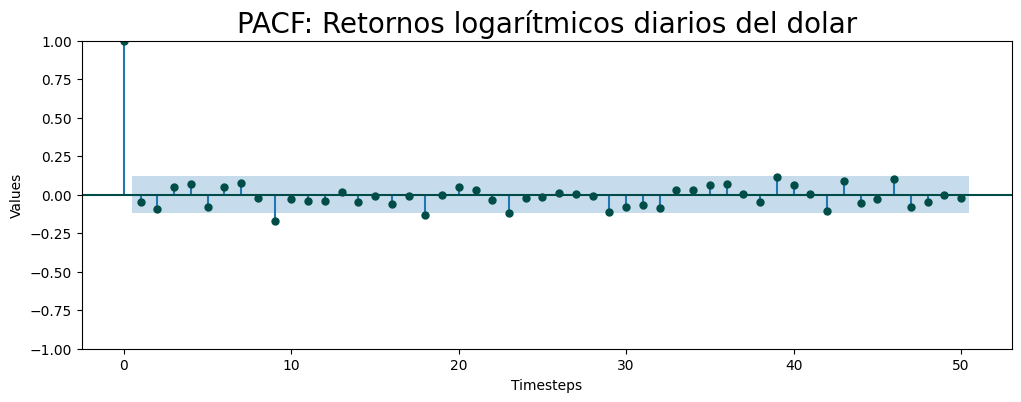

In [14]:
# PACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_pacf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'PACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

Analizando los gráficos de ACP y PACF, vemos que solo la serie de tiempo solo tiene autocorrleación con el primer lag, con el resto de valores pasados no se aprecia alguna correlación. Dada la falta de Autocorrelaciones, podemos suponer que el uso del modelo ARIMA puede que no nos llegue a realizar una buena predicción. Por ahora continuaremos con el ejercicio tomando $p,q=1$.

## 3.3 Modelo ARIMA

### 3.3.1 Split data
Tomaremos el último **mes** como test y entrenaremos con el resto de datos.

In [15]:
train_data = data.iloc[:-20,:].copy()
test_data = data.iloc[-20:,:].copy()

print(train_data.shape)
print(test_data.shape)

(241, 2)
(20, 2)


### 3.3.2 Train

In [16]:
# MODELO ARIMA
model_arma = ARIMA(
    train_data['log_returns'],
    order=(1, 0, 1),
    enforce_stationarity=False,
)

model_arma_fitted = model_arma.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
print(model_arma_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                  241
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 780.722
Date:                Sun, 06 Apr 2025   AIC                          -1553.444
Time:                        15:27:44   BIC                          -1539.538
Sample:                             0   HQIC                         -1547.840
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.385      0.166      -0.000       0.002
ar.L1         -0.3249      0.860     -0.378      0.706      -2.010       1.360
ma.L1          0.2885      0.871      0.331      0.7

### 3.3.3 Test

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


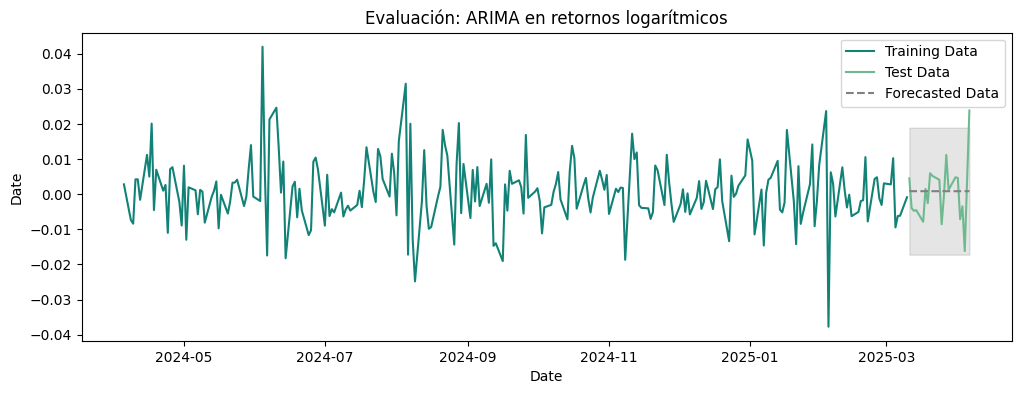

RMSE: 0.0083
MAE: 0.0063


In [18]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_series = pd.Series(test_forecast.predicted_mean.values, index=test_data.index)

# metrics
mse = mean_squared_error(test_data['log_returns'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['log_returns'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(train_data['log_returns'], label='Training Data', color='#128277')
plt.plot(test_data['log_returns'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.1)
plt.title('Evaluación: ARIMA en retornos logarítmicos')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


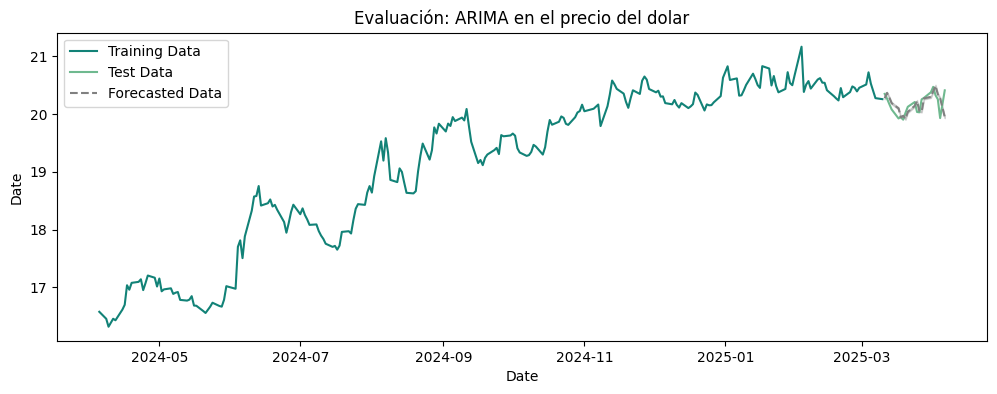

RMSE: 0.1668
MAE: 0.1274


In [19]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_values = test_forecast.predicted_mean.values

# inverse log return
for index,val in enumerate(test_forecast_values):
  test_forecast_values[index] = np.exp(val)*data['dollar_price'].iloc[-21+index]

test_forecast_series = pd.Series(test_forecast_values, index=test_data.index)
# metrics
mse = mean_squared_error(test_data['dollar_price'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['dollar_price'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(train_data['dollar_price'], label='Training Data', color='#128277')
plt.plot(test_data['dollar_price'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('Evaluación: ARIMA en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


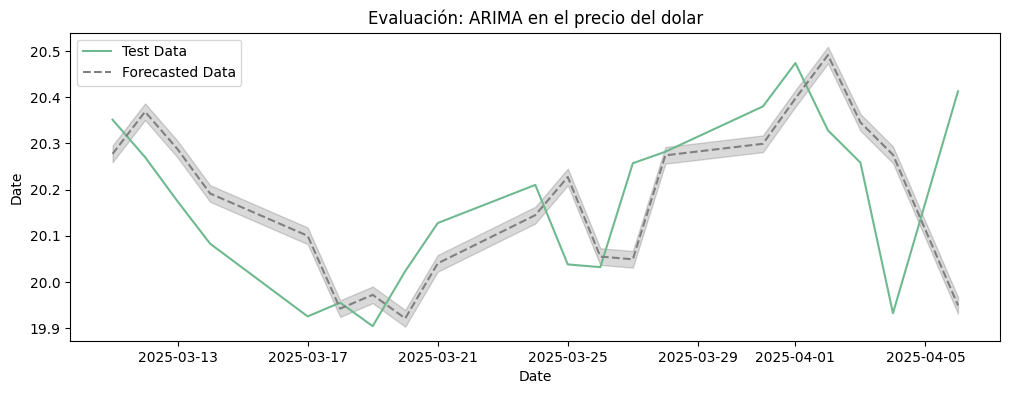

RMSE: 0.1668
MAE: 0.1274


In [20]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_values = test_forecast.predicted_mean.values

# inverse log return
for index,val in enumerate(test_forecast_values):
  test_forecast_values[index] = np.exp(val)*data['dollar_price'].iloc[-21+index]

test_forecast_series = pd.Series(test_forecast_values, index=test_data.index)
# metrics
mse = mean_squared_error(test_data['dollar_price'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['dollar_price'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(test_data['dollar_price'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('Evaluación: ARIMA en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

### 3.3.4. Conclusión

El modelo ARIMA a pesar de tener métricas de RMSE y MAE bajas, podemos notar en el último gráfico que la predicción obtenida es tan solo el valor anterior. Por ende el modelo no logra capturar completamente el comportamiento de la serie de tiempo. Probemos con otros métodos.

# 4. Forecasting con GARCH

Dado que ya hemos procesado y analizado los datos, iremos directamente al proceso de modelado con GARCH.*texto en cursiva*

In [30]:
daily_volatility = data['log_returns'].std()
print(f'Volatilidad Diaria: {daily_volatility:.4f}')

monthly_volatility = np.sqrt(21) * daily_volatility
print(f'Volatilidad Mensual: {monthly_volatility:.4f}')

yearly_volatility = np.sqrt(252) * daily_volatility
print(f'Volatilidad Anual: {yearly_volatility:.4f}')

Volatilidad Diaria: 0.0091
Volatilidad Mensual: 0.0419
Volatilidad Anual: 0.1451


## 4.1 Train

In [34]:
model_garch = arch_model(
    train_data['log_returns']*100, # Multiplicar por 100 para cambiar la escala
    mean='Zero',
    vol='ARCH',
    p=1,
    q=1
)

model_garch_fitted = model_garch.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 391.43338973255146
Iteration:      2,   Func. Count:     10,   Neg. LLF: 332.3476541196919
Iteration:      3,   Func. Count:     15,   Neg. LLF: 312.61279031094637
Iteration:      4,   Func. Count:     17,   Neg. LLF: 312.61279031097723
Optimization terminated successfully    (Exit mode 0)
            Current function value: 312.61279031094637
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4


In [36]:
print(model_garch_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -312.613
Distribution:                  Normal   AIC:                           629.226
Method:            Maximum Likelihood   BIC:                           636.195
                                        No. Observations:                  241
Date:                Sun, Apr 06 2025   Df Residuals:                      241
Time:                        15:45:21   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5953      0.132      4.508  6.536e-06   [  0.33

## 4.2 Test

In [44]:
train_volatility = model_garch_fitted.conditional_volatility / 100 # regresar a la escala

forecasts = model_garch_fitted.forecast(horizon=20)
forecast_volatility = pd.Series(
    forecasts.variance[-1:].values.flatten(),
    index=test_data.index) / 100 #regresar a la escala

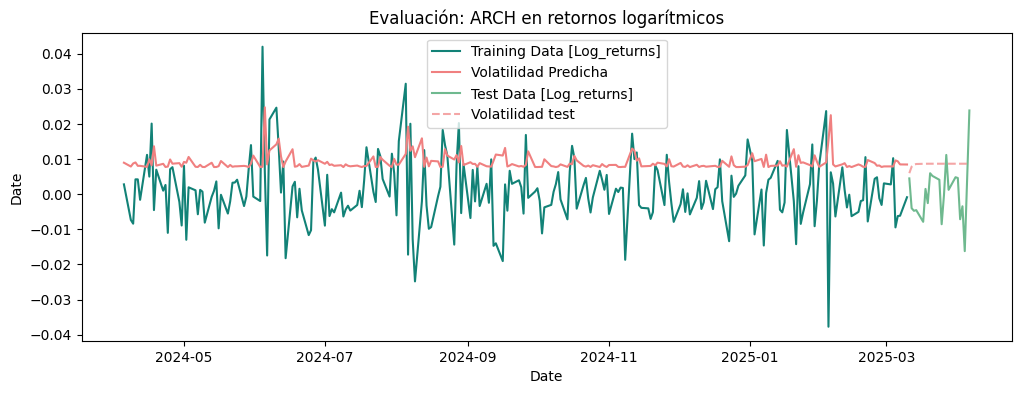

In [53]:
# plot
plt.figure(figsize=(12,4))

plt.plot(train_data['log_returns'], label='Training Data [Log_returns]', color='#128277')
plt.plot(train_volatility, label='Volatilidad Predicha', color='lightcoral')


plt.plot(test_data['log_returns'], label='Test Data [Log_returns]', color='#6FB98F',)
plt.plot(forecast_volatility, label='Volatilidad test', color='lightcoral', alpha=0.7, linestyle='--')

plt.title('Evaluación: ARCH en retornos logarítmicos')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()


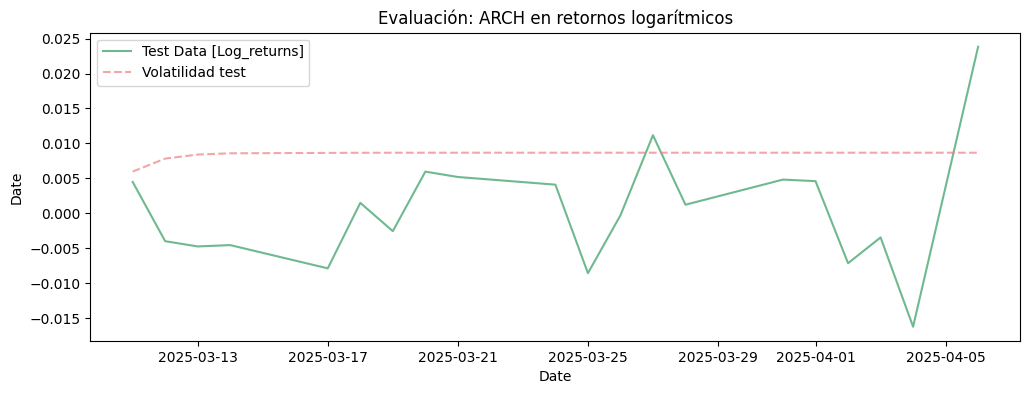

In [50]:
# plot
plt.figure(figsize=(12,4))
plt.plot(test_data['log_returns'], label='Test Data [Log_returns]', color='#6FB98F',)
plt.plot(forecast_volatility, label='Volatilidad test', color='lightcoral', alpha=0.7, linestyle='--')

plt.title('Evaluación: ARCH en retornos logarítmicos')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

# 4. Forecasting con LSTM

## 4.1 Preparación de los datos

In [68]:
# tomando un n_steps hacia atrás
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    y = np.array(y)


    return  X, y

In [177]:
n_steps_back = 5

# last month for testing
train_data = data.iloc[:-20,:].copy()
test_data = data.iloc[-20:,:].copy()

X_train, y_train = create_sequences(
    train_data['dollar_price'].values,
    n_steps=n_steps_back
)

X_test, y_test = create_sequences(
    test_data['dollar_price'].values,
    n_steps=n_steps_back
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(236, 5, 1) (236,)
(15, 5, 1) (15,)


## 4.2 Arquitectura de LSTM

La red a implementar tendrá en su capa de entrada la cantidad de lags a tomar hacia atrás (2), luego una capa LSTM con 64 neuronas, después una capa Densa con (32) neuronas con función de activación relu y finalmente una capa de salida con un solo valor, la cuál será nuestra predicción.


In [198]:
model_lstm = keras.models.Sequential([
    layers.Input((n_steps_back, 1), name = 'price_input'),
    layers.LSTM(units=32,  name='first_lstm', return_sequences=True), # 64 neuronas
    layers.LSTM(32, name='second_lstm', activation="softmax"), # 64 neuronas
    #layers.Dense(32, name='first_dense',activation='relu'), # 32 neuronas
    layers.Dense(16, name='second_dense',activation='softmax'), # 32 neuronas
    layers.Dense(1, name='output')
    ]
)

model_lstm.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error']
)


model_lstm.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_lstm (LSTM)                    │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_lstm (LSTM)                   │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_dense (Dense)                 │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

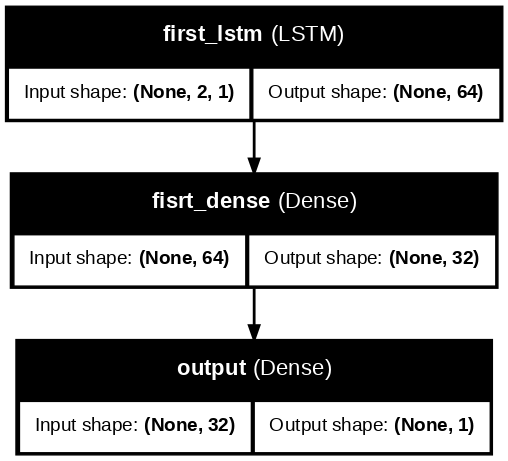

In [199]:
# Visualización del modelo
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=100,
)


## 4.2 Training

In [ ]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size = n_steps_back,
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 371.7627 - mean_absolute_error: 19.2382
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 361.2550 - mean_absolute_error: 18.9612
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 362.3962 - mean_absolute_error: 18.9905
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 356.6402 - mean_absolute_error: 18.8383
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 351.0338 - mean_absolute_error: 18.6926
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 348.6895 - mean_absolute_error: 18.6291
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 342.9208 - mean_absolute_error: 18.4762
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.9026 - mean_absolute_error: 18.3932
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 333.1343 - mean_absolute_error: 18.2095
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 329.1055 - mean_absolute_error: 18.0944
Epoch 11

## 4.3 Test

In [ ]:
# Graficar la función de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento', color='turquoise')
plt.title('Función de Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model_lstm.predict(X_train)
y_test_pred = model_lstm.predict(X_test)

y_train_pred = pd.Series(
    y_train_pred.ravel(),
    index=train_data.iloc[n_steps_back:,].index
)
y_test_pred = pd.Series(
    y_test_pred.ravel(),
    index=test_data.iloc[n_steps_back:,].index
)


In [ ]:
# metrics
rmse = mean_squared_error(y_train, y_train_pred)**0.5
mae = mean_absolute_error(y_train, y_train_pred)

print('Train Metrics:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

print('-'*20)

rmse = mean_squared_error(y_test, y_test_pred)**0.5
mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


In [ ]:
# plot
plt.figure(figsize=(12,4))

plt.plot(pd.Series(y_train, index=y_train_pred.index), label='TrainData', color='#128277')
plt.plot(y_train_pred, label='Train Prediction ', color='lightcoral')

plt.plot(pd.Series(y_test, index=y_test_pred.index) , label='Test Data', color='#6FB98F',)
plt.plot(y_test_pred, label='Test Prediction', color='lightcoral', alpha=0.7, linestyle='--')

plt.title('Evaluación: LSTM en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

In [ ]:
# plot
plt.figure(figsize=(12,4))

plt.plot(pd.Series(y_test, index=y_test_pred.index), label='Test Data', color='#6FB98F',)
plt.plot(y_test_pred, label='Test Prediction', color='lightcoral', alpha=0.7, linestyle='--')

plt.title('Evaluación: LSSTM en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()